# Verlet for a chain of coupled nonlinear springs

In the last notebook we saw how to implement the Verlet integrator for a system of three equal masses and four identical springs, with the ends fixed at the walls as shown in the figure.

<img src="./masses.jpg" alt="drawing" width="300"/>

We wrote the equations of motion in terms of the displacement of each mass from its equilibrium position. If we set the spring constants to be equal then for a simple Hookean spring with 

$$F = -k\Delta x$$ 

we had for the $j^th$ mass:

$$F_j = dx_{j+1} - 2dx_j + dx_{j-1}$$

Now we make the springs nonlinear, adding a cubic term to the force with force constant $\beta$:

$$F = -k\Delta x - \beta (\Delta x^3)$$

In terms of the displacements, the force on the $j^th$ mass becomes

$$F_j = dx_{j+1} - 2dx_j + dx_{j-1}$$


Our code has three main steps:
1. Set the initial position of one (or more) of the masses perturbed from its equilibrium position.
2. Perform one integratiom step with Euler-Cromer.
3. Perform N integration steps with Verlet, using the force above

Notice that (much like in TDSE leapfrog code), we have a loop over the masses inside the Verlet integration loop.

Let's have a look at how to implement this in code.

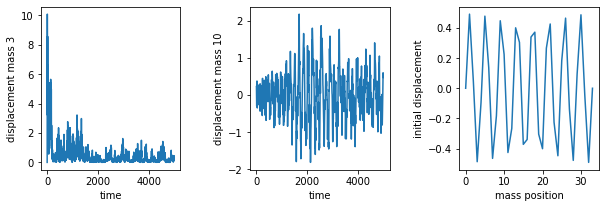

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# verlet integrator for the linear springs
def linear (x,x_prev,xL,xR,t2):
    x_new = 2.0*x - x_prev +(xL-2.0*x+xR)*t2
    return(x_new)

# verlet integrator for the nonlinear springs
def nonlin (x,x_prev,xL,xR,t2,beta):
    x_new = 2.0*x - x_prev +(xL-2.0*x+xR-beta*(x-xL)**3-beta*(x-xR)**3)*t2
    return(x_new)

# calculates the energy in each normal mode. Eq 19 from 2nd HO notebook
# indexing of masses is shifted by one to make use of list.append
def calc_E(N_mass,dx_t=[],V_t=[]):

    energy = []
    for n in range(1,N_mass+1):
        An = 0
        An_dot = 0
        for j in range(0,N_mass):
            An = An + dx_t[j]*np.sin(n*np.pi*(j+1)/(N_mass+1))
            An_dot = An_dot + V_t[j]*np.sin(n*np.pi*(j+1)/(N_mass+1))
        omega_n = 2.0*np.sin(n*np.pi/(2.0*(N_mass+1)))
        En = (An_dot**2 + (omega_n*An)**2)/(N_mass+1)
        energy.append(En)

    return(energy)
    


dt = 0.1
dt2 = dt**2
N_step = 5000
N_mass = 32
beta = 10.0
amp = 2.0
n_start = 16 ## this is the index of the initial eigenmode


# the normalization of the normal modes (Eq. 10)
eig_norm = np.sqrt(2/(N_mass+1))

# I'll create a 2D array to store the displacements of the masses
# at each time step. the columns will be the masses, the rows the timesteps
# being a python neophyte, I have no idea if this is dumb.
# the structure is dX[row][column] = dx[time][mass_j]. I'll stick to using
# i for the timestep and j for the mass index

# NOTE: we include the position and velocity of the x[0] and x[N+1] "masses",
# aka the boundaries, but just initialize dX[0], dX[N+1] v[0], and v[N+1] to 0 and 
# and never update them.
# this simplifies the logic in the loops over masses, since you don't need 
# to treat the ends differently from the middle

dX = [[0.0 for j in range(0,N_mass+2)] for i in range(N_step+1)]
V = [[0.0 for j in range(0,N_mass+2)] for i in range(N_step+1)]
Energy = [[0.0 for j in range(0,N_mass+2)] for i in range(N_step+1)]

for i in range(N_step+1):
    dX[i][N_mass+1] = 0.0


#initialize to a chosen eigenmode "n_start" using Eq. 16 
dX[0][0] = 0.0
dX[0][N_mass+1] = 0.0
for j in range(1,N_mass+1):
    tmp = float(j)
    dX[0][j] = amp*eig_norm*np.sin(n_start*np.pi*tmp/(N_mass+1))


#one E-C step
for j in range(1,N_mass+1):
    V[1][j] = V[0][j] + (dX[0][j-1] - 2.0*dX[0][j] + dX[0][j+1])*dt
for j in range(1,N_mass+1):
    dX[1][j] = dX[0][j] + V[1][j]*dt


##########################
#                        #
# now the Verlet loop    #
#                        # 
##########################

# i indexes the timestep, j indexes the mass
# these lists are used to pass stuff back and forth to the energy subroutine
tmp_E = []
dx_tmp = []
V_tmp = []
for i in range (2,N_step+1):
    for j in range(1,N_mass+1):
        #nonlinear version
        dX[i][j] = nonlin(dX[i-1][j],dX[i-2][j],dX[i-1][j-1],dX[i-1][j+1],dt2,beta)
        
        #linear version
        #dX[i][j] = linear(dX[i-1][j],dX[i-2][j],dX[i-1][j-1],dX[i-1][j+1],dt2)
        
        # velocity
        V[i-1][j] = (dX[i][j] - dX[i-2][j])/(2.0*dt)
        
        # so ugly. I really need to work on my python. must be a 
        # more elegant way to pass lists and arrays back and forth to
        # subroutines. oh well. it's sunday. it works. fuck it.
        #dx_tmp.append(dX[i-1][j])
        #V_tmp.append(V[i-1][j])        
    
    #tmp_E = calc_E(N_mass,dx_tmp,V_tmp)
    #print("Energy in each normal mode\n")
    #sum = 0
    for n in range(1,N_mass+1):
        An = 0
        An_dot = 0
        for j in range(1,N_mass+1):
            An = An + dX[i-1][j]*np.sin(n*np.pi*(j)/(N_mass+1))
            An_dot = An_dot + V[i-1][j]*np.sin(n*np.pi*(j)/(N_mass+1))
        omega_n = 2.0*np.sin(n*np.pi/(2.0*(N_mass+1)))
        En = (An_dot**2 + (omega_n*An)**2)/(N_mass+1)
        Energy[i-1][n] = En
    #print(En)
    #sum = sum + En
#print("TOTAL:", sum)
#print("\n")

    
    # fill array with the energy of each mode at each timestep
    #for j in range(1,N_mass+1):
        #Energy[i-1][j-1] = tmp_E[j-1]


## At the end of the Verlet loop Energy[timestep][mode] 
## contains the energyb of each mode as a function of time
## the indexing of the modes is shifted by 1: ie Energy[10][0] 
## is the energy in the 1st mode at the 10th timestep
##
##  This is the thing you need to answer all of the questions
## in the final FPU assignment. 


###### Figures ######

tmp_array = []
tmp_array2 = []
for i in range(0,N_step):
    tmp_array.append(Energy[i][16])
    tmp_array2.append(dX[i][10])

plt.figure(1, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(131)
ax.set_xlabel('time')
ax.set_ylabel('displacement mass 3')
#ax.set_xlim(right=40)
plt.plot(tmp_array)

ax2 = plt.subplot(132)
ax2.set_xlabel('time')
ax2.set_ylabel('displacement mass 10')
#ax2.set_xlim(right=40)
plt.plot(tmp_array2)

ax3 = plt.subplot(133)
ax3.set_xlabel('mass position')
ax3.set_ylabel('initial displacement')
plt.plot(dX[0])

plt.show()

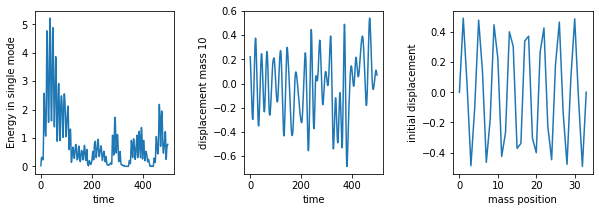

In [95]:
###### Figures ######

tmp_array = []
tmp_array2 = []
for i in range(1,N_step):
    tmp_array.append(Energy[i][18])
    tmp_array2.append(dX[i][10])

plt.figure(1, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(131)
ax.set_xlabel('time')
ax.set_ylabel('Energy in single mode')
#ax.set_xlim(right=40)
plt.plot(tmp_array)

ax2 = plt.subplot(132)
ax2.set_xlabel('time')
ax2.set_ylabel('displacement mass 10')
#ax2.set_xlim(right=40)
plt.plot(tmp_array2)

ax3 = plt.subplot(133)
ax3.set_xlabel('mass position')
ax3.set_ylabel('initial displacement')
plt.plot(dX[0])

plt.show()